This notebook demostrates how our script works. Check out the main code here - https://github.com/Mainakdeb/e_summit


## Clone our repository to access training data:

In [2]:
!git clone https://github.com/Mainakdeb/e_summit.git

Cloning into 'e_summit'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 266 (delta 0), reused 0 (delta 0), pack-reused 263
Receiving objects: 100% (266/266), 9.93 MiB | 20.96 MiB/s, done.
Resolving deltas: 100% (144/144), done.


## Install socialreaper version 0.3.0
Most of the dependencies needed are already available in colab, when running the script locally, make sure to run 
```
pip install -r requirements.txt
```

In [3]:
!pip3 install socialreaper==0.3.0

In [4]:
import optparse
import pickle
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
#from data_prep import DataPrep
from sklearn.feature_extraction.text import TfidfVectorizer

from socialreaper import Twitter
from socialreaper.tools import to_csv

## Train Classifier:
Run the following cell to begin training. It requires approximately 5 minutes.

In case you dont want to train, you can access pretrained models from this [Google drive link](https://drive.google.com/drive/folders/1oG_EZlshqx3leaMN41mQsZLKeYZdKocD?usp=sharing). Add the folder as shortcut to your drive and run the following code in a new cell
```
from google.colab import drive
drive.mount('/content/drive')
```
Now you'll get access to google drive folders from colab.


In [5]:
import pandas as pd

class DataPrep():
    def __init__(self):
        self.trait_cat_dict = {
            'O': 'cOPN',
            'C': 'cCON',
            'E': 'cEXT',
            'A': 'cAGR',
            'N': 'cNEU',
            'OPN': 'cOPN',
            'CON': 'cCON',
            'EXT': 'cEXT',
            'AGR': 'cAGR',
            'NEU': 'cNEU',
            'Openness': 'cOPN',
            'Conscientiousness': 'cCON',
            'Extraversion': 'cEXT',
            'Agreeableness': 'cAGR',
            'Neuroticism': 'cNEU'
            }
        self.trait_score_dict = {
            'O': 'sOPN',
            'C': 'sCON',
            'E': 'sEXT',
            'A': 'sAGR',
            'N': 'sNEU',
            'OPN': 'sOPN',
            'CON': 'sCON',
            'EXT': 'sEXT',
            'AGR': 'sAGR',
            'NEU': 'sNEU',
            'Openness': 'sOPN',
            'Conscientiousness': 'sCON',
            'Extraversion': 'sEXT',
            'Agreeableness': 'sAGR',
            'Neuroticism': 'sNEU'
            }
        self.LIWC_features = [
            'WPS', 'Unique', 'Dic', 'Sixltr', 'Negate', 'Assent', 'Article', 'Preps', 'Number',
            'Pronoun', 'I', 'We', 'Self', 'You', 'Other',
            'Affect', 'Posemo', 'Posfeel', 'Optim', 'Negemo', 'Anx', 'Anger', 'Sad',
            'Cogmech', 'Cause', 'Insight', 'Discrep', 'Inhib', 'Tentat', 'Certain',
            'Senses', 'See', 'Hear', 'Feel',
            'Social', 'Comm', 'Othref', 'Friends', 'Family', 'Humans',
            'Time', 'Past', 'Present', 'Future',
            'Space', 'Up', 'Down', 'Incl', 'Excl', 'Motion',
            'Occup', 'School', 'Job', 'Achieve',
            'Leisure', 'Home', 'Sports', 'TV', 'Music',
            'Money',
            'Metaph', 'Relig', 'Death', 'Physcal', 'Body', 'Sexual', 'Eating', 'Sleep', 'Groom',
            'Allpct', 'Period', 'Comma', 'Colon', 'Semic', 'Qmark', 'Exclam', 'Dash', 'Quote', 'Apostro', 'Parenth', 'Otherp',
            'Swear', 'Nonfl', 'Fillers',
        ]

    def prep_data(self, type, trait, regression=False, model_comparison=False):
        df_status = self.prep_status_data()
        tfidf = TfidfVectorizer(stop_words='english', strip_accents='ascii')
        if type == 'essay':
            if model_comparison:
                X = tfidf.fit_transform(df_essay['TEXT'])
            else:
                X = df_essay['TEXT']

            y_column = self.trait_cat_dict[trait]
            y = df_essay[y_column]

        elif type == 'status':
            other_features_columns = [
                'NETWORKSIZE',
                'BETWEENNESS',
                'NBETWEENNESS',
                'DENSITY',
                'BROKERAGE',
                'NBROKERAGE',
                'TRANSITIVITY'
            ]
            if model_comparison:
                X = tfidf.fit_transform(df_status['STATUS'])
                # X = np.nan_to_num(np.column_stack((result, df_status[other_features_columns])))
            # Data to fit production model
            else:
                X = df_status['STATUS']
            if regression:
                y_column = self.trait_score_dict[trait]
            else:
                y_column = self.trait_cat_dict[trait]
            y = df_status[y_column]
        return X, y

    def prep_status_data(self):
        df = pd.read_csv('/content/e_summit/data/mypersonality_final.csv', encoding="ISO-8859-1")
        df = self.convert_traits_to_boolean(df)
        return df

    def prep_essay_data(self):
        df_essays = pd.read_csv('data/personality-detection-my-copy/essays.csv', encoding="ISO-8859-1")
        df_mairesse = pd.read_csv('data/personality-detection-my-copy/mairesse.csv', encoding="ISO-8859-1", header=None)
        df_mairesse.columns = ['#AUTHID'] + self.LIWC_features
        df = df_essays.merge(df_mairesse, how = 'inner', on = ['#AUTHID'])
        # add word count (WC) column
        df['WC'] = df['TEXT'].str.split().str.len()
        df = self.convert_traits_to_boolean(df)
        return df

    def convert_traits_to_boolean(self, df):
        trait_columns = ['cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU']
        d = {'y': True, 'n': False}

        for trait in trait_columns:
            df[trait] = df[trait].map(d)
        return df

    def load_data(self, filepath):
        return pd.read_csv(filepath, encoding="ISO-8859-1")
        
class Model():
    def __init__(self):
        self.rfr = RandomForestRegressor(bootstrap=True,
         max_features='sqrt',
         min_samples_leaf=1,
         min_samples_split=2,
         n_estimators= 200)
        self.rfc = RandomForestClassifier(max_features='sqrt', n_estimators=110)
        self.tfidf = TfidfVectorizer(stop_words='english', strip_accents='ascii')

    def fit(self, X, y, regression=True):
        X = self.tfidf.fit_transform(X)
        if regression:
            self.rfr = self.rfr.fit(X, y)
        else:
            self.rfc = self.rfc.fit(X, y)

    def predict(self, X, regression=True):
        X = self.tfidf.transform(X)
        if regression:
            return self.rfr.predict(X)
        else:
            return self.rfc.predict(X)

    def predict_proba(self, X, regression=False):
        X = self.tfidf.transform(X)
        if regression:
            raise ValueError('Cannot predict probabilites of a regression!')
        else:
            return self.rfc.predict_proba(X)

traits = ['OPN', 'CON', 'EXT', 'AGR', 'NEU']
model = Model()

for trait in traits:
    dp = DataPrep()
    X_regression, y_regression = dp.prep_data('status', trait, regression=True, model_comparison=False)
    X_categorical, y_categorical = dp.prep_data('status', trait, regression=False, model_comparison=False)
    print('Fitting trait ' + trait + ' regression model...')
    model.fit(X_regression, y_regression, regression=True)
    print('Done!')
    print('Fitting trait ' + trait + ' categorical model...')
    model.fit(X_categorical, y_categorical, regression=False)
    print('Done!')
    with open('/content/' + trait + '_model.pkl', 'wb') as f:
        # Write the model to a file.
        pickle.dump(model, f)

Fitting trait OPN regression model...
Done!
Fitting trait OPN categorical model...
Done!
Fitting trait CON regression model...
Done!
Fitting trait CON categorical model...
Done!
Fitting trait EXT regression model...
Done!
Fitting trait EXT categorical model...
Done!
Fitting trait AGR regression model...
Done!
Fitting trait AGR categorical model...
Done!
Fitting trait NEU regression model...
Done!
Fitting trait NEU categorical model...
Done!


## Load the classifiers:

In [6]:
import pickle
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
#from data_prep import DataPrep
from sklearn.feature_extraction.text import TfidfVectorizer

class Model():
    def __init__(self):
        self.rfr = RandomForestRegressor(bootstrap=True,
         max_features='sqrt',
         min_samples_leaf=1,
         min_samples_split=2,
         n_estimators= 200)
        self.rfc = RandomForestClassifier(max_features='sqrt', n_estimators=110)
        self.tfidf = TfidfVectorizer(stop_words='english', strip_accents='ascii')

    def fit(self, X, y, regression=True):
        X = self.tfidf.fit_transform(X)
        if regression:
            self.rfr = self.rfr.fit(X, y)
        else:
            self.rfc = self.rfc.fit(X, y)

    def predict(self, X, regression=True):
        X = self.tfidf.transform(X)
        if regression:
            return self.rfr.predict(X)
        else:
            return self.rfc.predict(X)

    def predict_proba(self, X, regression=False):
        X = self.tfidf.transform(X)
        if regression:
            raise ValueError('Cannot predict probabilites of a regression!')
        else:
            return self.rfc.predict_proba(X)

M = Model()
models={}
traits = ['OPN', 'CON', 'EXT', 'AGR', 'NEU']
for trait in traits:
    with open('/content/' + trait + '_model.pkl', 'rb') as f:
        models[trait] = pickle.load(f)

## Define get_profile( ):
the get_profile( ) function takes keywords/names as input and returns corresponding social media id's as a dictionary.

In [7]:
from googlesearch import search
import re

def get_profile(keyword):
  print("getting profiles from google..")
  results = list(search(keyword, num=10))
  profiles = {
      'twitter': ''
  }
  for r in results:
    if r.find('twitter') != -1 and profiles['twitter'] == '':
      r = re.search(r'https://twitter.com/([^/?]+)', r).group(1)
      profiles['twitter'] = r

  return profiles

## Define get_text_from_tweets( ) :
this function below takes the twitter username (string) as input, then gets rid of special characters using regex, and returns tweets corresponding to that user in form of a string. 

In the main script, we have saved the scraped tweets as information.txt to adhere with the problem statement.

In [9]:
twt = Twitter(app_key="PDz1fZLoCEHcOx035TtLsrcWS", 
              app_secret="Ok1aJBP4nM6g87F3hFiPFY0R0a7qnUNsdIoKZteaAuzYF2yTuF", 
              oauth_token="1292034807057149952-3Mlqa59ZAoqRdACgnW6z4goXUy3vUs", 
              oauth_token_secret="ZZlu7jF3mymeapDxwj19MkqCYF3osQjp48xYEuIL4wRM1")
    
def get_text_from_tweets(user_name):
    print("processing text from tweets..")
    tweets = twt.user(user_name, 
                    count=1000, 
                    exclude_replies=False, 
                    include_retweets=True)
        
    to_csv(list(tweets), filename=user_name+'_tweets.csv')

    tweets_df = pd.read_csv(user_name+"_tweets.csv")
    just_tweets=tweets_df[["text"]]
    ##remove urls 
    no_urls = just_tweets['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    #just_text_from_tweets.head(50)
    no_urls=no_urls.to_frame()

    # convert rows to a string
    tweets_string = ""
    for idx,row in no_urls.iterrows():
        tweets_string += (row['text'] + '. ')

    clean_text = re.sub("[^A-Za-z0-9. ]"," ",tweets_string)
    clean_text = clean_text.strip()
    return(clean_text)


## Define predict_personality( )
This function accepts a string as input and returns an array of floats, each corresponding to one of 5 personality traits.

In [10]:
def predict(X):
        X=[X]
        predictions = {}
        traits = ['OPN', 'CON', 'EXT', 'AGR', 'NEU']
        for trait in traits:
            pkl_model = models[trait]
            trait_scores = pkl_model.predict(X, regression=True).reshape(1, -1)
            # scaler = MinMaxScaler(feature_range=(0, 50))
            # print(scaler.fit_transform(trait_scores))
            # scaled_trait_scores = scaler.fit_transform(trait_scores)
            predictions['pred_s'+trait] = trait_scores.flatten()[0]
            # predictions['pred_s'+trait] = scaled_trait_scores.flatten()

            trait_categories = pkl_model.predict(X, regression=False)
            predictions['pred_c'+trait] = str(trait_categories[0])
            # predictions['pred_c'+trait] = trait_categories

            trait_categories_probs = pkl_model.predict_proba(X)
            predictions['pred_prob_c'+trait] = trait_categories_probs[:, 1][0]
            # predictions['pred_prob_c'+trait] = trait_categories_probs[:, 1]
        return predictions

## Define display_results( ):
This function plots a bar chart, representing each of the 5 OCEAN tendencies of the user.

In [11]:
def display_results(predictions, user_name):
    attrs = [predictions['pred_prob_cOPN'],
             predictions['pred_prob_cCON'],
             predictions['pred_prob_cEXT'],
             predictions['pred_prob_cAGR'],
             predictions['pred_prob_cNEU']]

    plt.rcParams["figure.figsize"] = (12, 6)
    #plt.style.use('ggplot')
    plt.ylim([0.0,1.0])
    plt.bar(['Openness','Conscientiousness','Extraverison','Agreeableness','Neuroticism'],attrs, color =('green', 'black', 'pink', 'orange', 'yellow'), alpha=0.5)
    plt.xlabel("Attribute")
    plt.ylabel("Tendency")
    plt.title(user_name+"'s Personality Report")
    plt.grid()
    plt.show()

##Moment of truth:
Feel free to replace Elon Musk with Chetan Bhagat, Ratan Tata etc.


In [12]:
user_name = get_profile("Elon Musk tesla spacex")['twitter']
text = get_text_from_tweets(user_name)
predictions = predict(text)
#display_results(predictions=predictions, user_name=user_name)

getting profiles from google..
processing text from tweets..


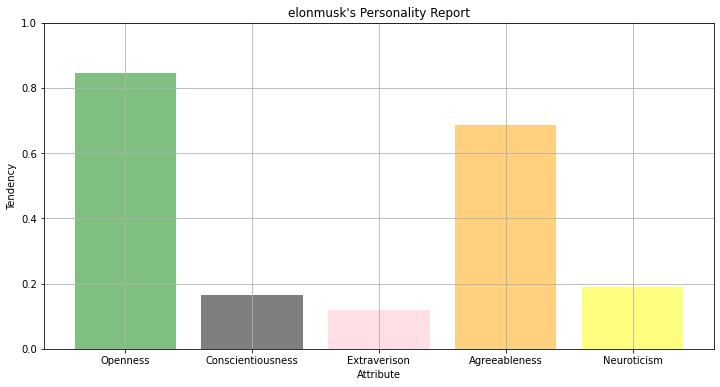

In [13]:
display_results(predictions=predictions, user_name=user_name)

The main script accepts a file names.txt, and generates 2 files, information.txt and predictions.txt

Do check out the main script - https://github.com/Mainakdeb/e_summit